In [1]:
#https://ruslanmv.com/blog/Forecast-of-Natural-Gas-Price-with-Deep-Learning
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt                       
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import time
from datetime import date
from datetime import datetime

In [2]:
today = date.today()
print("Today's date:", today)
to_today = datetime.strptime(str(today), '%Y-%m-%d').strftime('%d/%m/%Y')
to_date = datetime.strptime(str(today), '%Y-%m-%d').strftime('%Y-%m-%d')

Today's date: 2024-01-03


In [3]:
def addonDays(a, x):
   ret = time.strftime("%Y-%m-%d",time.localtime(time.mktime(time.strptime(a,"%Y-%m-%d"))+x*3600*24+3600))      
   return ret

In [4]:
week_ago=addonDays(to_date, -7)
week_ago

'2023-12-27'

In [5]:
#import gas price data
import yfinance as yf
import yfinance as yf
# Get the data for the stock S&P 500 index fund data
start = '2013-01-01'
end = '2023-12-31'
ticker_symbol = 'NWN'

df = yf.download(ticker_symbol, start, end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,44.889999,44.930000,44.450001,44.849998,30.046885,167800
2013-01-03,44.889999,44.959999,44.459999,44.740002,29.973190,81200
2013-01-04,44.959999,45.599998,44.830002,45.450001,30.448849,158700
2013-01-07,45.230000,45.230000,44.369999,44.419998,29.758810,86900
2013-01-08,44.450001,44.680000,44.110001,44.450001,29.778902,136200
...,...,...,...,...,...,...
2023-12-22,38.790001,39.439999,38.660000,39.160000,39.160000,153200
2023-12-26,39.049999,39.330002,38.950001,39.110001,39.110001,129800
2023-12-27,39.310001,39.310001,38.869999,39.160000,39.160000,199700


In [10]:
df['Date'] = df.index

In [12]:
df = df[["Date", "Close"]]
df=df.reset_index(drop=True)

In [13]:
df.head()

,Date,Close
0,2013-01-02,44.849998
1,2013-01-03,44.740002
2,2013-01-04,45.450001
3,2013-01-07,44.419998
4,2013-01-08,44.450001


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2768 non-null   datetime64[ns]
 1   Close   2768 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 43.4 KB


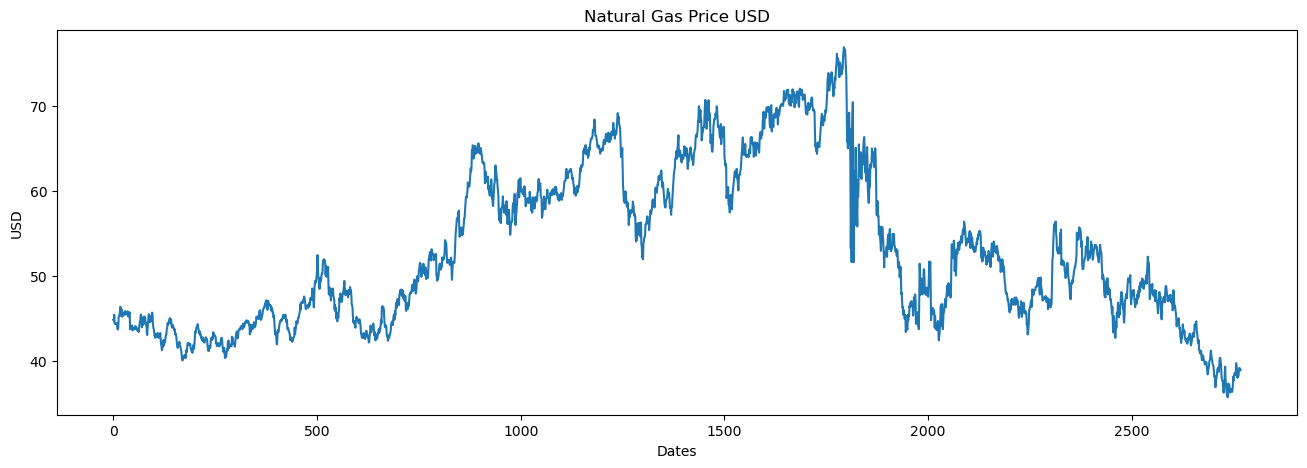

In [19]:
ax = df['Close'].plot(figsize = (16,5), title = 'Natural Gas Price USD')
ax.set(xlabel='Dates', ylabel='USD');

In [29]:
df = df.set_index("Date")
df.head()

,Close
Date,
2013-01-02,44.849998
2013-01-03,44.740002
2013-01-04,45.450001
2013-01-07,44.419998
2013-01-08,44.450001


In [30]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2)

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [32]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

array([[0.7031135 ],
       [0.22505516],
       [0.28389306],
       ...,
       [0.54155429],
       [0.48761949],
       [0.21892621]])

In [35]:
from keras.preprocessing.sequence import TimeseriesGenerator
# Let's redefine to get 24 days  back and then predict the next day out
n_input = 24
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, 
                                length=n_input, batch_size=1)

In [36]:
X,y = generator[0]

In [37]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.7031135  0.22505516 0.28389306 0.1041922  0.16817849 0.34395681
 0.91566555 0.26648685 0.54890902 0.52586419 0.21647457 0.2637901
 0.58494729 0.36675653 0.69600389 0.38734981 0.72002947 0.74503552
 0.22064231 0.16425596 0.5329737  0.47609703 0.70409415 0.57710224]
Predict this y: 
 [[0.56974742]]


In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [41]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
2190/2190 [==============================] - 14s 6ms/step - loss: 0.0565
Epoch 2/20
2190/2190 [==============================] - 12s 6ms/step - loss: 0.0534
Epoch 3/20
2190/2190 [==============================] - 12s 5ms/step - loss: 0.0533
Epoch 4/20
2190/2190 [==============================] - 12s 6ms/step - loss: 0.0532
Epoch 5/20
2190/2190 [==============================] - 12s 6ms/step - loss: 0.0528
Epoch 6/20
2190/2190 [==============================] - 12s 6ms/step - loss: 0.0527
Epoch 7/20
2190/2190 [==============================] - 12s 6ms/step - loss: 0.0526
Epoch 8/20
2190/2190 [==============================] - 12s 6ms/step - loss: 0.0527
Epoch 9/20
2190/2190 [==============================] - 12s 6ms/step - loss: 0.0526
Epoch 10/20
2190/2190 [==============================] - 12s 6ms/step - loss: 0.0526
Epoch 11/20
2190/2190 [==============================] - 12s 6ms/step - loss: 0.0527
Epoch 12/20
2190/2190 [==============================] - 12s 5ms/step - lo

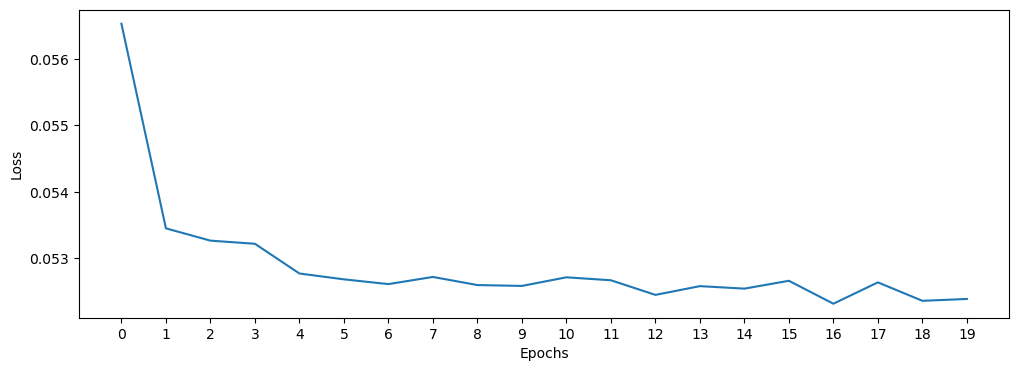

In [42]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [43]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


In [44]:
lstm_predictions_scaled

[array([0.42948428], dtype=float32),
 array([0.41471332], dtype=float32),
 array([0.41085237], dtype=float32),
 array([0.40993315], dtype=float32),
 array([0.4102171], dtype=float32),
 array([0.41071406], dtype=float32),
 array([0.41116756], dtype=float32),
 array([0.41151452], dtype=float32),
 array([0.411763], dtype=float32),
 array([0.41193327], dtype=float32),
 array([0.4120488], dtype=float32),
 array([0.41212463], dtype=float32),
 array([0.41217485], dtype=float32),
 array([0.41220737], dtype=float32),
 array([0.41222852], dtype=float32),
 array([0.41224223], dtype=float32),
 array([0.41225088], dtype=float32),
 array([0.41225648], dtype=float32),
 array([0.41225994], dtype=float32),
 array([0.41226214], dtype=float32),
 array([0.41226354], dtype=float32),
 array([0.4122642], dtype=float32),
 array([0.41226473], dtype=float32),
 array([0.41226506], dtype=float32),
 array([0.4122651], dtype=float32),
 array([0.4122653], dtype=float32),
 array([0.41226542], dtype=float32),
 array([

In [46]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [47]:
lstm_predictions

array([[53.6286647 ],
       [53.02615744],
       [52.86866927],
       [52.83117417],
       [52.84275675],
       [52.8630275 ],
       [52.88152584],
       [52.89567828],
       [52.90581426],
       [52.9127592 ],
       [52.917471  ],
       [52.9205648 ],
       [52.92261315],
       [52.92393941],
       [52.92480251],
       [52.9253617 ],
       [52.92571424],
       [52.92594278],
       [52.92608379],
       [52.92617375],
       [52.92623088],
       [52.92625763],
       [52.92627951],
       [52.92629288],
       [52.9262941 ],
       [52.92630261],
       [52.92630747],
       [52.92631111],
       [52.92631355],
       [52.92631476],
       [52.92631476],
       [52.92631598],
       [52.92631598],
       [52.92631719],
       [52.92631719],
       [52.92631719],
       [52.92631598],
       [52.92631598],
       [52.92631719],
       [52.92631598],
       [52.92631719],
       [52.92631598],
       [52.92631719],
       [52.92631598],
       [52.92631719],
       [52

In [48]:
test_data['LSTM_Predictions'] = lstm_predictions

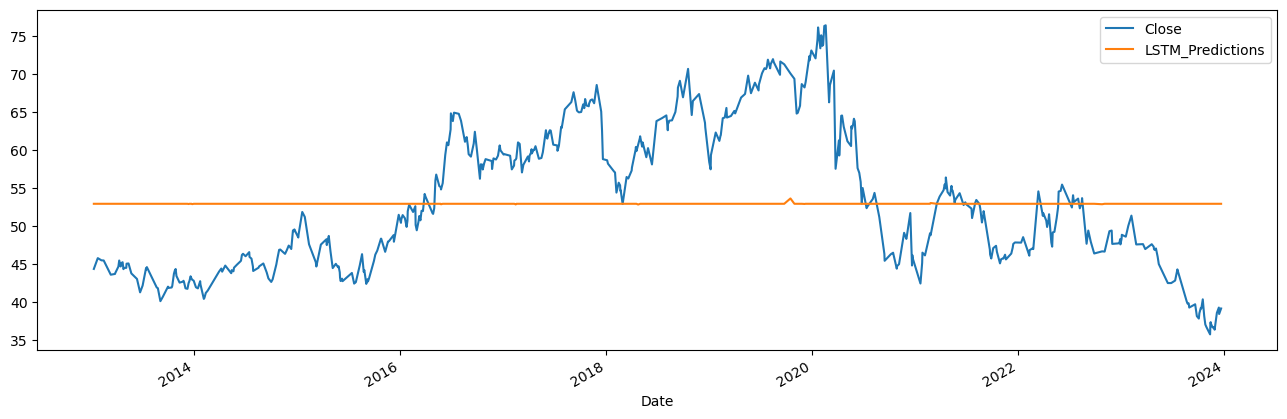

In [49]:
test_data['Close'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [50]:
lstm_rmse_error = rmse(test_data['Close'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 88.17792107581893
RMSE Error: 9.390309956323003
Mean: 53.05831647470507


In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu',return_sequences=True,
                    input_shape=(n_input, n_features)))
lstm_model.add(LSTM(200, return_sequences=True))
lstm_model.add(Dropout(rate=0.2))
lstm_model.add(LSTM(200, return_sequences=False))
lstm_model.add(Dense(1))

mc = ModelCheckpoint('double_model_lstm.h5', monitor='val_loss', mode='min', 
                     verbose=1, save_best_only=True)

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 200)           161600    
                                                                 
 lstm_2 (LSTM)               (None, 24, 200)           320800    
                                                                 
 dropout (Dropout)           (None, 24, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [52]:
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
2190/2190 [==============================] - 79s 34ms/step - loss: 0.0567
Epoch 2/20
2190/2190 [==============================] - 76s 35ms/step - loss: 0.0541
Epoch 3/20
2190/2190 [==============================] - 75s 34ms/step - loss: 0.0534
Epoch 4/20
2190/2190 [==============================] - 81s 37ms/step - loss: 0.0531
Epoch 5/20
2190/2190 [==============================] - 82s 38ms/step - loss: 0.0531
Epoch 6/20
2056/2190 [===========================>..] - ETA: 4s - loss: 0.0526

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=12)

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test_data,scaled_test_data, 
                                           length=n_input)

In [ ]:
lstm_model.compile(optimizer='adam', 
              loss='mse')

In [ ]:
# fit model
lstm_model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop, mc])

In [ ]:
losses = pd.DataFrame(lstm_model.history.history)
losses.plot()

In [ ]:
from keras.models import load_model

lstm_model = load_model('double_model_lstm.h5', compile=False)

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    lstm_pred = lstm_model.predict(current_batch)[0]
    
    # store prediction
    lstm_predictions_scaled.append(lstm_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions

In [ ]:
test_data['Close'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error = rmse(test_data['Close'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 7 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
#one week
periods = 7

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
test_data.tail()

In [ ]:
week_ago=addonDays(to_date, -7)

In [ ]:
next_week=addonDays(to_date, 7)

In [ ]:
next_month=addonDays(to_date, 30)

In [ ]:
forecast_index = pd.date_range(start=to_date,periods=periods,freq='D')

In [ ]:
forecast_index

In [ ]:
DatetimeIndex(['2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
               '2022-07-15', '2022-07-16', '2022-07-17'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])
forecast_df

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

In [ ]:
month_ago=addonDays(to_date, -30)

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim(month_ago,next_week)

In [ ]:
fig3 = make_subplots(specs=[[{"secondary_y": True}]])
fig3.add_trace(go.Scatter(x=forecast_df.index,y=forecast_df['Forecast'],name='Forecast'))
fig3.add_trace(go.Scatter(x=df.index,y=df['Close'],name='Close'))
fig3.update_layout(title={'text':gas_result.name+' ('+ default_currency +')', 'x':0.5})
fig3.update_yaxes(range=[0,1000000000],secondary_y=True)
fig3.update_yaxes(visible=False, secondary_y=True)
fig3.update_layout(xaxis_rangeslider_visible=False)  #hide range slider
fig3.show()